In [3]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import model_selection,metrics,ensemble,linear_model,naive_bayes,gaussian_process,neighbors,svm,tree,discriminant_analysis
from sklearn.model_selection import ShuffleSplit,train_test_split,RandomizedSearchCV, GridSearchCV,StratifiedKFold,RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score,roc_auc_score,classification_report,precision_recall_curve,f1_score,auc,roc_curve,average_precision_score,confusion_matrix
import xgboost
from xgboost import XGBClassifier,plot_importance
import seaborn as sns


In [7]:
Inp_data = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data",sep='\s+',header=None)

"Renaming as per german.doc"

Inp_data.columns=['Checking_Status','Duration_in_months','Credit_history','Loan_purpose','Credit_amount','Savings_status','Time_in_curr_emp',
                  'Inst_to_Income','Personal_status','guarantors','Time_at_curr_res','Property_Type','Age_in_years','Other_installments',
                  'Housing','Existing_credits_count','Employment','No_of_dependents','Phone','Foreign_worker','Target']
Inp_data.dtypes

Checking_Status           object
Duration_in_months         int64
Credit_history            object
Loan_purpose              object
Credit_amount              int64
Savings_status            object
Time_in_curr_emp          object
Inst_to_Income             int64
Personal_status           object
guarantors                object
Time_at_curr_res           int64
Property_Type             object
Age_in_years               int64
Other_installments        object
Housing                   object
Existing_credits_count     int64
Employment                object
No_of_dependents           int64
Phone                     object
Foreign_worker            object
Target                     int64
dtype: object

In [8]:
Num_Vars= ['Duration_in_months','Credit_amount','Inst_to_Income','Time_at_curr_res',
                    'Age_in_years','Existing_credits_count','No_of_dependents','Target']

Cat_Vars= ['Checking_Status','Credit_history','Loan_purpose','Savings_status','Time_in_curr_emp','Personal_status',
                   'guarantors','Property_Type','Other_installments','Housing','Employment','Phone','Foreign_worker']


" Key- 1:Good(No default), 2: Bad(Default)"
"Transforming labels"
Inp_data['Target']= Inp_data['Target']-1

In [9]:
##Data Sanitization##########

def missing(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing(Inp_data)


,Total,Percent
Target,0,0.0
guarantors,0,0.0
Duration_in_months,0,0.0
Credit_history,0,0.0
Loan_purpose,0,0.0
Credit_amount,0,0.0
Savings_status,0,0.0
Time_in_curr_emp,0,0.0
Inst_to_Income,0,0.0
Personal_status,0,0.0


In [8]:
## Event rate####
print('Event rate is', (Inp_data[Inp_data['Target']==1].shape[0]/Inp_data.shape[0])*100,'%')

Event rate is 30.0 %


In [9]:
Summary= Inp_data.describe(percentiles=[.005,.01,0.05,0.1,0.25,0.5,.75,.90,.950,.990,.995,.999])
Summary=Summary.transpose()
print(Summary)

                         count      mean          std    min     0.5%      1%  \
Duration_in_months      1000.0    20.903    12.058814    4.0    4.000    6.00   
Credit_amount           1000.0  3271.258  2822.736876  250.0  361.905  425.83   
Inst_to_Income          1000.0     2.973     1.118715    1.0    1.000    1.00   
Time_at_curr_res        1000.0     2.845     1.103718    1.0    1.000    1.00   
Age_in_years            1000.0    35.546    11.375469   19.0   20.000   20.00   
Existing_credits_count  1000.0     1.407     0.577654    1.0    1.000    1.00   
No_of_dependents        1000.0     1.155     0.362086    1.0    1.000    1.00   
Target                  1000.0     0.300     0.458487    0.0    0.000    0.00   

                            5%    10%     25%     50%      75%     90%  \
Duration_in_months        6.00    9.0    12.0    18.0    24.00    36.0   
Credit_amount           708.95  932.0  1365.5  2319.5  3972.25  7179.4   
Inst_to_Income            1.00    1.0     2.0   

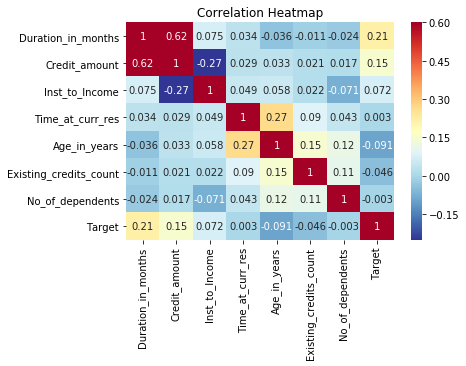

In [10]:
#####Correlation Heatmap#####

Inp_data_corrs= Inp_data[Num_Vars].corr()
sns.heatmap(Inp_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001CC0FF800F0>,
      dtype=object)

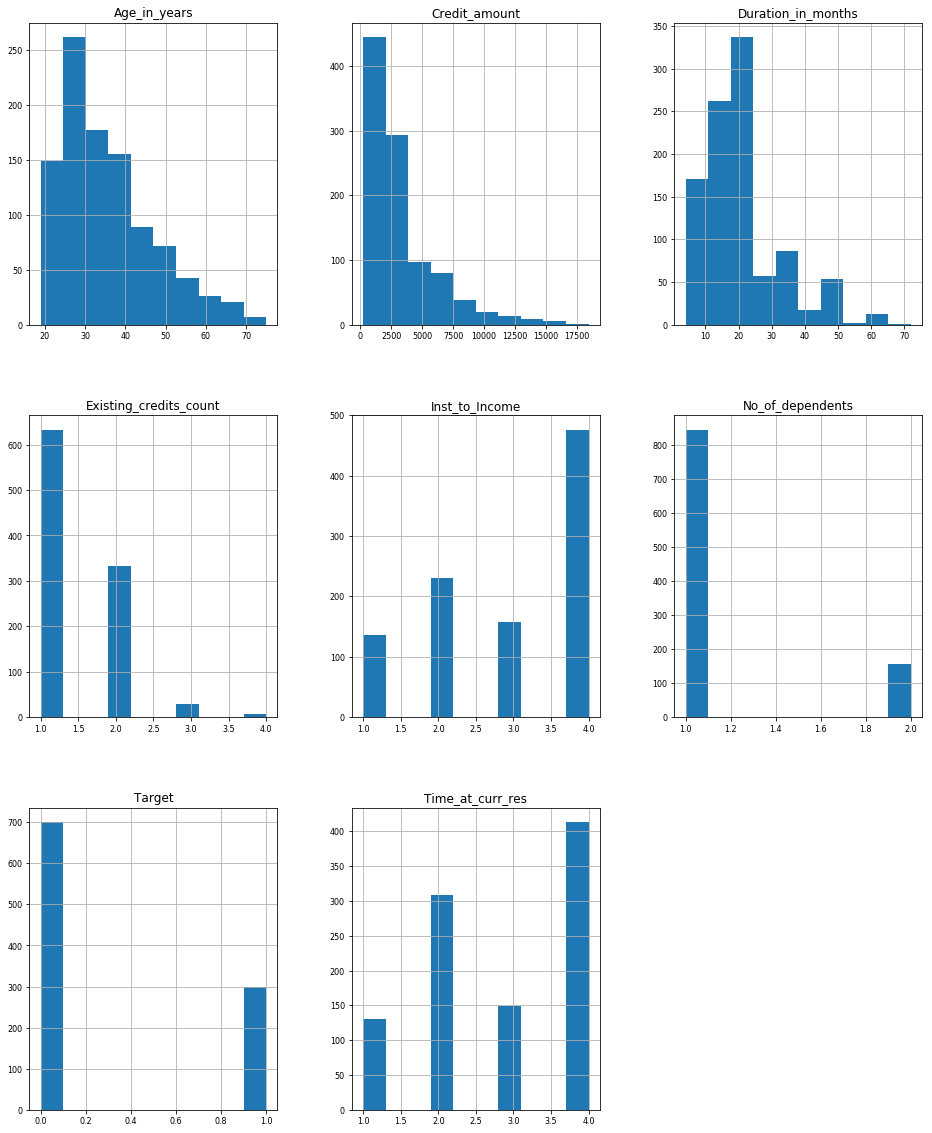

In [11]:
#Histogram for all

Inp_data.hist(figsize=(16, 20), bins=10, xlabelsize=8, ylabelsize=8)

<Figure size 432x288 with 0 Axes>

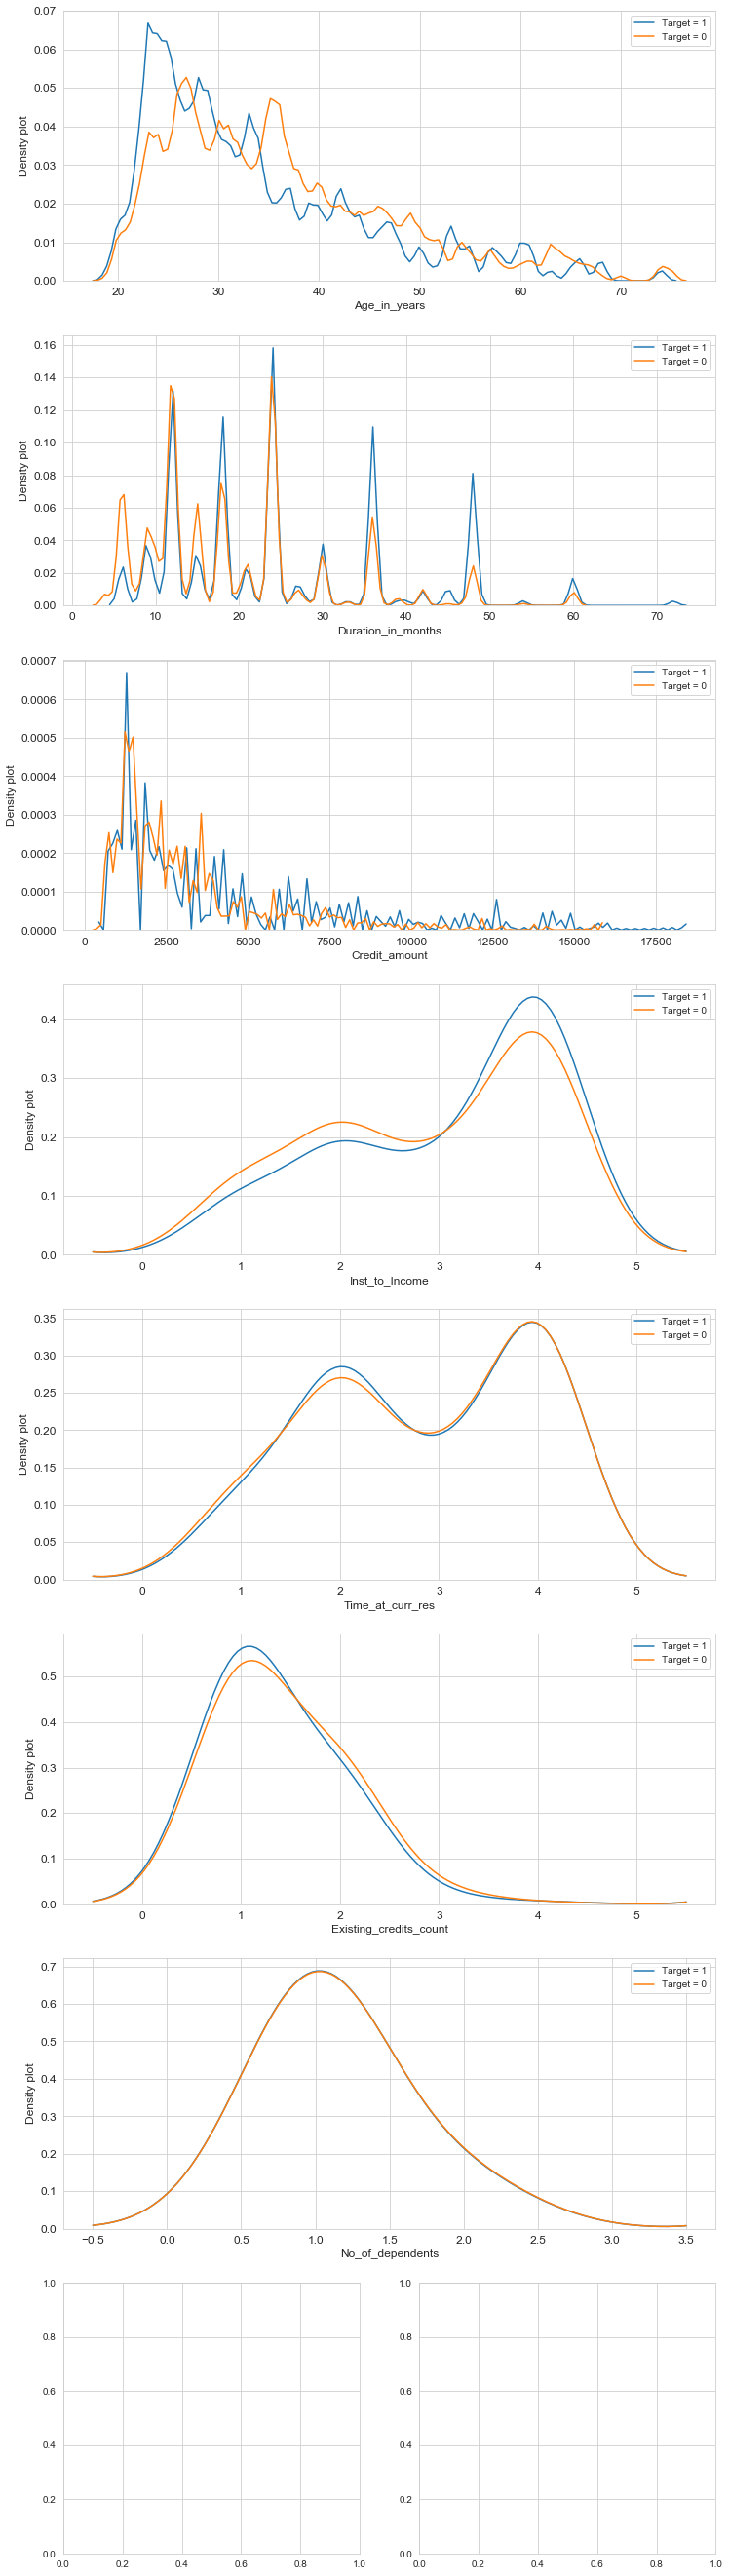

In [12]:
#Kernel Density Estimate

def plot_dist(var,nrow=8):    
    i = 0
    m1 = Inp_data.loc[Inp_data['Target'] != 0]
    m0 = Inp_data.loc[Inp_data['Target'] == 0]

    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(nrow,2,figsize=(12,6*nrow))

    for feature in var:
        i += 1
        plt.subplot(nrow,1,i)
        sns.kdeplot(m1[feature],bw=0.5, label="Target = 1")
        sns.kdeplot(m0[feature],bw=0.5, label="Target = 0")
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show();
       
var=['Age_in_years','Duration_in_months','Credit_amount','Inst_to_Income','Time_at_curr_res','Existing_credits_count','No_of_dependents']

plot_dist(var)



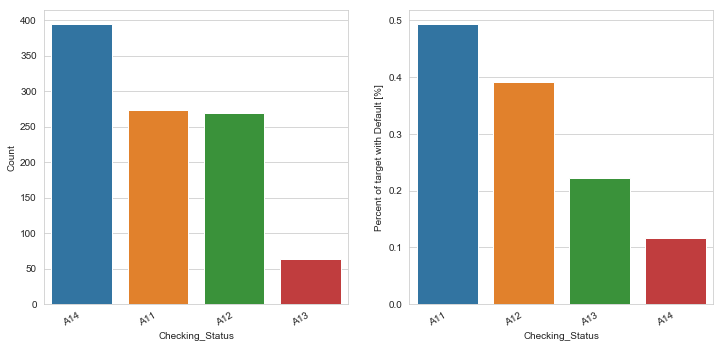

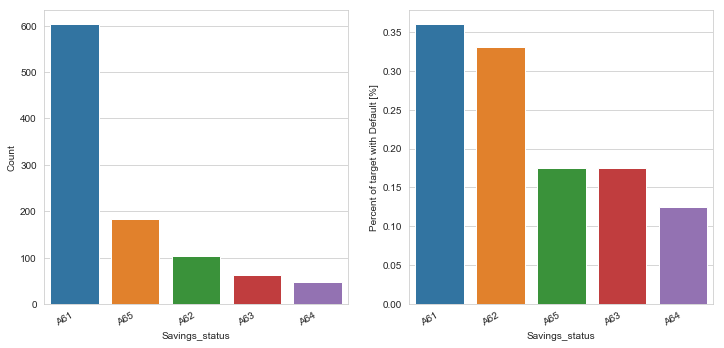

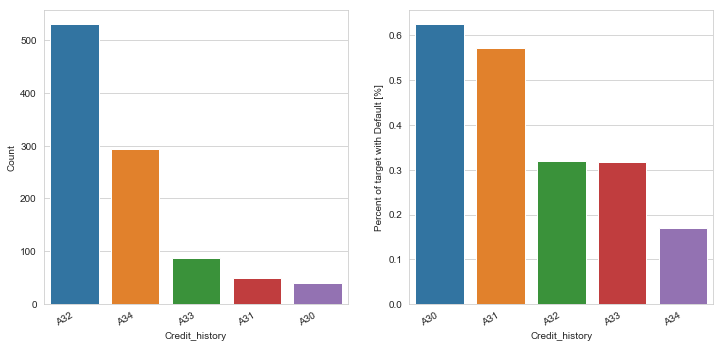

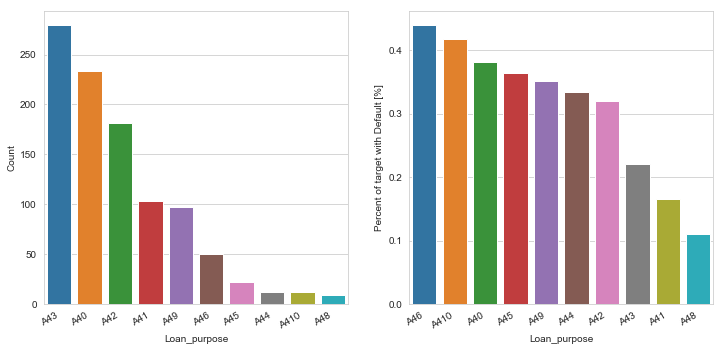

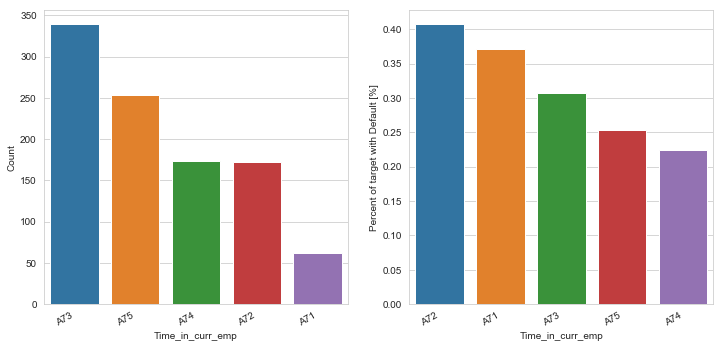

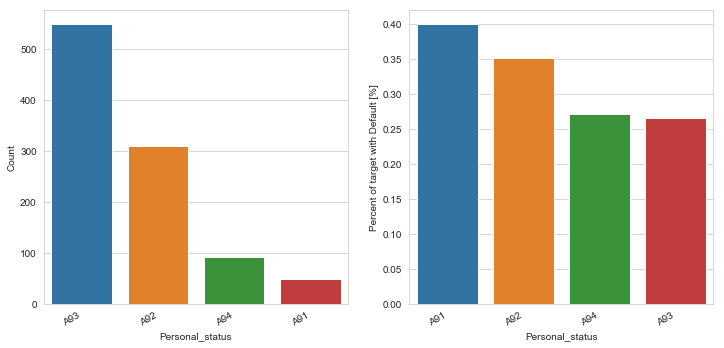

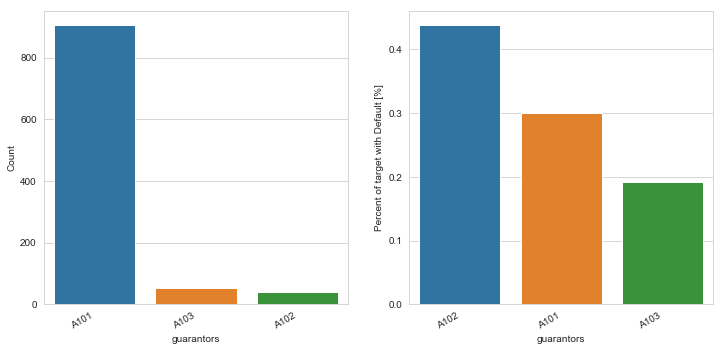

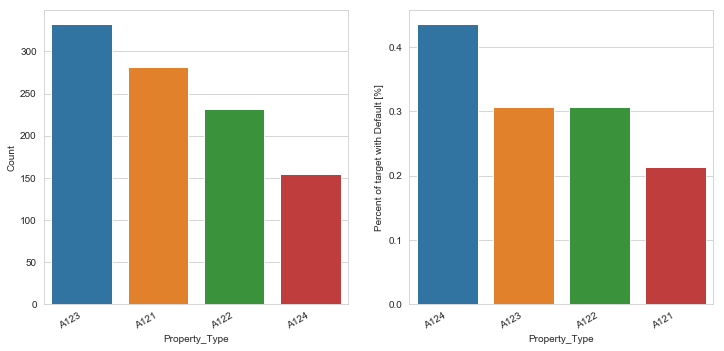

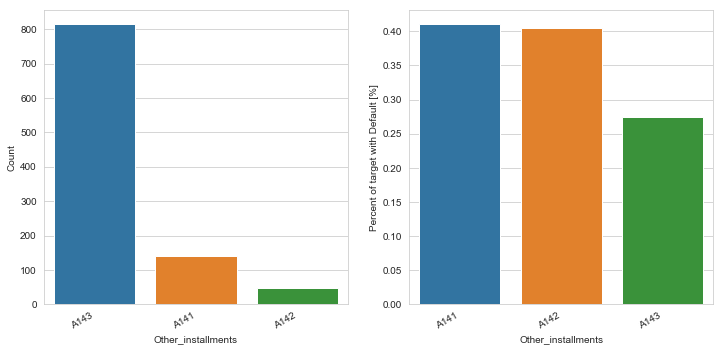

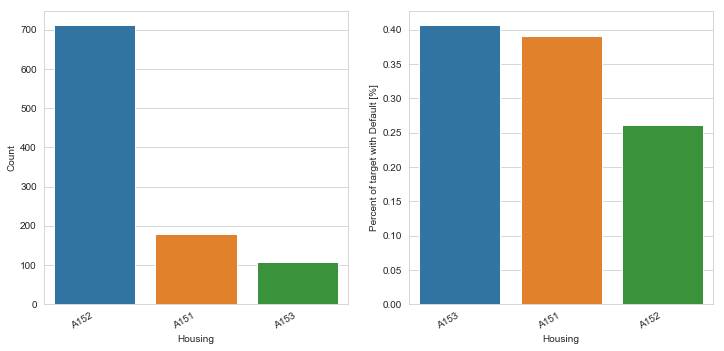

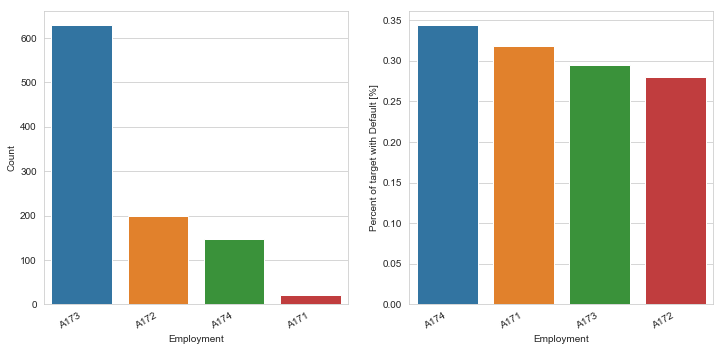

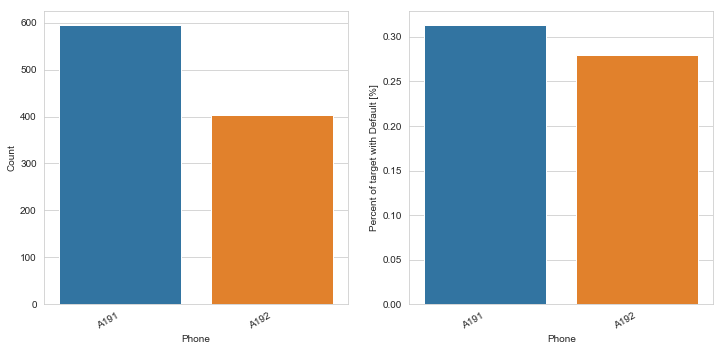

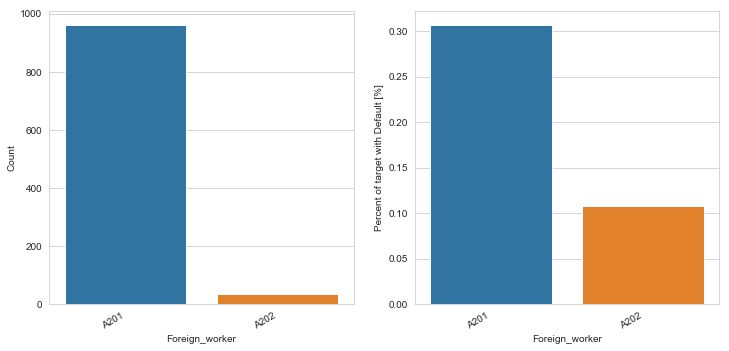

In [13]:
def Target_perc(feature,label_rotation=False,horizontal_layout=True):
    temp = Inp_data[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index,'Count': temp.values})

    # Calculate the percentage of target=1 per category value
    level_perc = Inp_data[[feature, 'Target']].groupby([feature],as_index=False).mean()
    level_perc.sort_values(by='Target', ascending=False, inplace=True)
    
    if(horizontal_layout):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,14))
    sns.set_color_codes("pastel")
    s = sns.barplot(ax=ax1, x = feature, y="Count",data=df1)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    fig.autofmt_xdate()
    s = sns.barplot(ax=ax2, x = feature, y='Target', order=level_perc[feature], data=level_perc)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.ylabel('Percent of target with Default [%]', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.show();
        
Target_perc('Checking_Status')
Target_perc('Savings_status')
Target_perc('Credit_history')
Target_perc('Loan_purpose')
Target_perc('Time_in_curr_emp')
Target_perc('Personal_status')
Target_perc('guarantors')
Target_perc('Property_Type')
Target_perc('Other_installments')
Target_perc('Housing')
Target_perc('Employment')
Target_perc('Phone')
Target_perc('Foreign_worker')

In [10]:
##### Encoding for categorical features
    
# Labelencoding to transform categorical to numerical
    
d1 = defaultdict(LabelEncoder)

# Encoding the variable
Cat_data = Inp_data[Cat_Vars].apply(lambda x: d1[x.name].fit_transform(x))

# print transformations
for x in range(len(Cat_Vars)):
    print(Cat_Vars[x],": ", Inp_data[Cat_Vars[x]].unique())
    print(Cat_Vars[x],": ", Cat_data[Cat_Vars[x]].unique())
    
#Create dummy variables for every category of every categorical variable

dummy = pd.get_dummies(Inp_data[Cat_Vars],drop_first=True)
Inp_data_Trans= pd.concat([Inp_data[Num_Vars], dummy], axis = 1)
Inp_data_Num= pd.concat([Inp_data[Num_Vars], Cat_data], axis = 1)


Checking_Status :  ['A11' 'A12' 'A14' 'A13']
Checking_Status :  [0 1 3 2]
Credit_history :  ['A34' 'A32' 'A33' 'A30' 'A31']
Credit_history :  [4 2 3 0 1]
Loan_purpose :  ['A43' 'A46' 'A42' 'A40' 'A41' 'A49' 'A44' 'A45' 'A410' 'A48']
Loan_purpose :  [4 7 3 0 1 9 5 6 2 8]
Savings_status :  ['A65' 'A61' 'A63' 'A64' 'A62']
Savings_status :  [4 0 2 3 1]
Time_in_curr_emp :  ['A75' 'A73' 'A74' 'A71' 'A72']
Time_in_curr_emp :  [4 2 3 0 1]
Personal_status :  ['A93' 'A92' 'A91' 'A94']
Personal_status :  [2 1 0 3]
guarantors :  ['A101' 'A103' 'A102']
guarantors :  [0 2 1]
Property_Type :  ['A121' 'A122' 'A124' 'A123']
Property_Type :  [0 1 3 2]
Other_installments :  ['A143' 'A141' 'A142']
Other_installments :  [2 0 1]
Housing :  ['A152' 'A153' 'A151']
Housing :  [1 2 0]
Employment :  ['A173' 'A172' 'A174' 'A171']
Employment :  [2 1 3 0]
Phone :  ['A192' 'A191']
Phone :  [1 0]
Foreign_worker :  ['A201' 'A202']
Foreign_worker :  [0 1]


In [11]:
#############Baseline Model( Fitting Suite of algorithms####################

X = Inp_data_Trans.loc[:,Inp_data_Trans.columns != 'Target']
Y = Inp_data_Trans.loc[:,'Target']

## Creating a validation dataset (Holdout sample####)

seed = 9
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [12]:
import warnings
warnings.filterwarnings('ignore')

ALG = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(max_iter=10000),

    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),

    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True,gamma='auto'),

    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),
    
    #XGBoost
    XGBClassifier()        
    ]

#Cross validation
cv_split = model_selection.StratifiedKFold(n_splits=10, random_state=None, shuffle=False )
#sklearn.metrics.SCORERS.keys()

scoring = ['accuracy','roc_auc', 'f1']
#create table to compare ALG metrics

ALG_columns = ['ALG Name', 'ALG Parameters','ALG Test Accuracy Mean', 'ALG Test Accuracy STD' ,'ALG Test ROC', 'ALG Test F1 score','ALG Time']
ALG_compare = pd.DataFrame(columns = ALG_columns)

#create table to compare ALG predictions
ALG_predict = pd.DataFrame(y_test)

#Index through ALG and save performance to table
row_index = 0
for algo in ALG:
    #set name and parameters
    ALG_name = algo.__class__.__name__
    ALG_compare.loc[row_index, 'ALG Name'] = ALG_name
    ALG_compare.loc[row_index, 'ALG Parameters'] = str(algo.get_params())  
    cv_results = model_selection.cross_validate(algo, X_train, y_train, cv = cv_split,scoring=scoring)
    ALG_compare.loc[row_index, 'ALG Time'] = cv_results['fit_time'].mean()
    ALG_compare.loc[row_index, 'ALG Test ROC'] = cv_results['test_roc_auc'].mean()
    ALG_compare.loc[row_index, 'ALG Test F1 score'] = cv_results['test_f1'].mean()
    ALG_compare.loc[row_index, 'ALG Test Accuracy Mean'] = cv_results['test_accuracy'].mean()   
    ALG_compare.loc[row_index, 'ALG Test Accuracy STD'] = cv_results['test_accuracy'].std()
    #save ALG predictions
    algo.fit(X_train, y_train)
    ALG_predict[ALG_name] = algo.predict_proba(X_test)[:,1]
    row_index+=1

#print and sort table

ALG_compare.sort_values(by = ['ALG Test ROC'], ascending = False, inplace = True)
print(ALG_compare)

                         ALG Name  \
5            LogisticRegressionCV   
3      GradientBoostingClassifier   
12     LinearDiscriminantAnalysis   
14                  XGBClassifier   
0              AdaBoostClassifier   
4          RandomForestClassifier   
13  QuadraticDiscriminantAnalysis   
7                      GaussianNB   
6                     BernoulliNB   
1               BaggingClassifier   
2            ExtraTreesClassifier   
10         DecisionTreeClassifier   
11            ExtraTreeClassifier   
8            KNeighborsClassifier   
9                             SVC   

                                       ALG Parameters ALG Test Accuracy Mean  \
5   {'Cs': 10, 'class_weight': None, 'cv': 'warn',...               0.744308   
3   {'criterion': 'friedman_mse', 'init': None, 'l...                0.74292   
12  {'n_components': None, 'priors': None, 'shrink...                0.74302   
14  {'base_score': 0.5, 'booster': 'gbtree', 'cols...               0.742857   
0   {'a

In [13]:
######## XGBoost & Logistic Regression models outperformed all###########
## Looks like the data is linearly separable.. Great from Credit risk modeling standpoint######
### First Create a Boosting model##

## Performing Feature Selection first######

## Feature Selection######

# Correlation

feature_name = X_train.columns.tolist()

def cor_selector(X_train, y_train):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X_train.columns.tolist():
        cor = np.corrcoef(X_train[i], y_train)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X_train.iloc[:,np.argsort(np.abs(cor_list))[-20:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature

cor_support, cor_feature = cor_selector(X_train, y_train)
print(str(len(cor_feature)), 'selected features')


#Chi Square####
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
X_norm = MinMaxScaler().fit_transform(X_train)
chi_selector = SelectKBest(chi2, k=20)
chi_selector.fit(X_norm, y_train)

chi_support = chi_selector.get_support()
chi_feature = X_train.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')

############################# Wrapper Methods##########################################

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=20, step=10, verbose=5)
rfe_selector.fit(X_norm, y_train)

rfe_support = rfe_selector.get_support()
rfe_feature = X_train.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')

###########################Embedded methods#############################################

## Logistic regression##

from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l1"), '1.25*median')
embeded_lr_selector.fit(X_norm, y_train)

embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X_train.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')

#### Random Forest####

from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=1000), threshold='1.25*median')
embeded_rf_selector.fit(X_train, y_train)

embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X_train.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')


###### Light GBM###########

from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMClassifier

lgbc=LGBMClassifier()
embeded_lgb_selector = SelectFromModel(lgbc, threshold='1.25*median')
embeded_lgb_selector.fit(X_train, y_train)
embeded_lgb_support = embeded_lgb_selector.get_support()
embeded_lgb_feature = X_train.loc[:,embeded_lgb_support].columns.tolist()
print(str(len(embeded_lgb_feature)), 'selected features')

######## Result#############

pd.set_option('display.max_rows', None)
# put all selection together
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support, 'Logistics':embeded_lr_support, 'Random Forest':embeded_rf_support, 'LightGBM':embeded_lgb_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 30
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df.head(48)



20 selected features
20 selected features
Fitting estimator with 48 features.
Fitting estimator with 38 features.
Fitting estimator with 28 features.
20 selected features
20 selected features
12 selected features
23 selected features


,Feature,Pearson,Chi-2,RFE,Logistics,Random Forest,LightGBM,Total
1,Duration_in_months,True,True,True,True,True,True,6
2,Credit_history_A34,True,True,True,True,True,True,6
3,Credit_amount,True,True,True,True,True,True,6
4,Checking_Status_A14,True,True,True,True,True,True,6
5,Time_in_curr_emp_A74,True,True,True,True,False,True,5
6,Savings_status_A65,True,True,True,True,False,True,5
7,Other_installments_A143,True,False,True,True,True,True,5
8,Loan_purpose_A43,True,True,True,True,False,True,5
9,Loan_purpose_A41,True,True,True,True,False,True,5
10,guarantors_A103,True,True,True,True,False,False,4


In [14]:
Remove_vars=['Time_in_curr_emp_A73',
            'Property_Type_A123',
            'Property_Type_A122',
            'Phone_A192',
            'Personal_status_A92',
            'Other_installments_A142',
            'Loan_purpose_A410',
            'Housing_A153',
            'Employment_A173',
            'Credit_history_A32',
            'guarantors_A102',
            'Savings_status_A63',
            'Savings_status_A62',
            'Personal_status_A94',
            'No_of_dependents',
            'Loan_purpose_A49',
            'Loan_purpose_A46',
            'Loan_purpose_A45',
            'Loan_purpose_A44',
            'Employment_A174',
            'Employment_A172',
            'Credit_history_A33'
]

X_train=X_train.drop(X_train[Remove_vars],axis=1)
X_test=X_test.drop(X_test[Remove_vars],axis=1)


Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  2.2min finished


Best: 0.773011 using {'learning_rate': 0.1, 'n_estimators': 300}
0.692055 (0.031158) with: {'learning_rate': 0.0001, 'n_estimators': 100}
0.693381 (0.030496) with: {'learning_rate': 0.0001, 'n_estimators': 200}
0.691995 (0.031620) with: {'learning_rate': 0.0001, 'n_estimators': 300}
0.694290 (0.034006) with: {'learning_rate': 0.0001, 'n_estimators': 400}
0.698012 (0.035950) with: {'learning_rate': 0.0001, 'n_estimators': 500}
0.697059 (0.036339) with: {'learning_rate': 0.0001, 'n_estimators': 600}
0.704446 (0.040960) with: {'learning_rate': 0.0001, 'n_estimators': 700}
0.706494 (0.042879) with: {'learning_rate': 0.0001, 'n_estimators': 800}
0.706305 (0.043023) with: {'learning_rate': 0.0001, 'n_estimators': 900}
0.704573 (0.048966) with: {'learning_rate': 0.0001, 'n_estimators': 1000}
0.704574 (0.049085) with: {'learning_rate': 0.001, 'n_estimators': 100}
0.707865 (0.053329) with: {'learning_rate': 0.001, 'n_estimators': 200}
0.718601 (0.058375) with: {'learning_rate': 0.001, 'n_estima

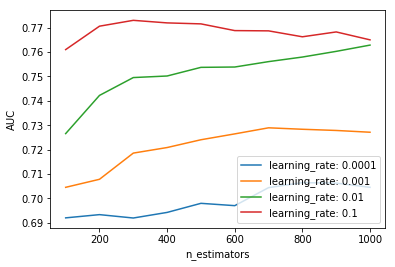

In [15]:
########## Selecting XGBoost Model and Tuning#######

model = XGBClassifier() 
n_estimators = [100,200,300,400,500,600,700,800,900,1000] 
learning_rate= [0.0001, 0.001, 0.01, 0.1]
param_grid = dict(n_estimators=n_estimators, learning_rate= learning_rate) 
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7) 
grid_search = GridSearchCV(model, param_grid, scoring="roc_auc", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(X_train, y_train)
  
# Summarizing results###
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_)) 
means = grid_result.cv_results_['mean_test_score'] 
stds = grid_result.cv_results_['std_test_score'] 
params = grid_result.cv_results_['params'] 
for mean, stdev, param in zip(means, stds, params): 
    print("%f (%f) with: %r" % (mean, stdev, param))

# Plotting results
scores = np.array(means).reshape(len(learning_rate), len(n_estimators))
for i, value in enumerate(learning_rate):
    plt.plot(n_estimators, scores[i], label='learning_rate: ' + str(value))
    plt.legend()
    plt.xlabel('n_estimators')
    plt.ylabel('AUC')
    plt.savefig('n_estimators_vs_learning_rate.png')



In [24]:
## Max depth and min child weight with with above learning rate and # of Trees#######

model = XGBClassifier() 
n_estimators = [300] 
learning_rate= [0.1]
max_depth = range(1, 11, 2)
min_child_weight= range(1,6,2)

param_grid = dict(n_estimators=n_estimators, learning_rate= learning_rate,max_depth=max_depth,min_child_weight=min_child_weight) 
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7) 
grid_search = GridSearchCV(model, param_grid, scoring="roc_auc", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   43.2s finished


Best: 0.773950 using {'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 300}
0.766778 (0.050283) with: {'learning_rate': 0.1, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 300}
0.766606 (0.048769) with: {'learning_rate': 0.1, 'max_depth': 1, 'min_child_weight': 3, 'n_estimators': 300}
0.767618 (0.051581) with: {'learning_rate': 0.1, 'max_depth': 1, 'min_child_weight': 5, 'n_estimators': 300}
0.773011 (0.044489) with: {'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300}
0.772940 (0.048217) with: {'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300}
0.763011 (0.059692) with: {'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300}
0.770318 (0.052597) with: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 300}
0.768508 (0.060291) with: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 300}
0.765555 (0.053053) with

In [26]:
## Tuning gamma###

model = XGBClassifier() 
n_estimators = [300] 
learning_rate= [0.1]
max_depth = range(1, 11, 2)
min_child_weight= range(1,6,2)
gamma= [i/10.0 for i in range(0,5)]

param_grid = dict(gamma=gamma,n_estimators=n_estimators, learning_rate= learning_rate,max_depth=max_depth,min_child_weight=min_child_weight) 
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7) 
grid_search = GridSearchCV(model, param_grid, scoring="roc_auc", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Fitting 10 folds for each of 75 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:  3.4min finished


Best: 0.781833 using {'gamma': 0.4, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 300}
0.766778 (0.050283) with: {'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 300}
0.766606 (0.048769) with: {'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 1, 'min_child_weight': 3, 'n_estimators': 300}
0.767618 (0.051581) with: {'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 1, 'min_child_weight': 5, 'n_estimators': 300}
0.773011 (0.044489) with: {'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300}
0.772940 (0.048217) with: {'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300}
0.763011 (0.059692) with: {'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300}
0.770318 (0.052597) with: {'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 300}
0.768508 (0.060291) w

In [16]:
model = XGBClassifier() 
n_estimators = [300] 
learning_rate= [0.1]
max_depth = [3]
min_child_weight= [1]
gamma= [0.4]
subsample = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
colsample_bytree = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
param_grid = dict(subsample=subsample,colsample_bytree=colsample_bytree,gamma=gamma,n_estimators=n_estimators, learning_rate= learning_rate,max_depth=max_depth,min_child_weight=min_child_weight) 
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7) 
grid_search = GridSearchCV(model, param_grid, scoring="roc_auc", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 10 folds for each of 81 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed:  1.9min finished


Best: 0.779112 using {'colsample_bytree': 0.8, 'gamma': 0.4, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.7}
0.751001 (0.051692) with: {'colsample_bytree': 0.1, 'gamma': 0.4, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.1}
0.767428 (0.046367) with: {'colsample_bytree': 0.1, 'gamma': 0.4, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.2}
0.766727 (0.040792) with: {'colsample_bytree': 0.1, 'gamma': 0.4, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.3}
0.772575 (0.044816) with: {'colsample_bytree': 0.1, 'gamma': 0.4, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.4}
0.773078 (0.044441) with: {'colsample_bytree': 0.1, 'gamma': 0.4, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.5}
0.776920 

In [17]:
## Tuning Reg alpha########
    
model = XGBClassifier() 
n_estimators = [300] 
learning_rate= [0.1]
max_depth = [3]
min_child_weight= [1]
gamma= [.4]
subsample = [.7]
colsample_bytree = [.8]
reg_alpha= [1e-4, 1e-2, 0.1, 1, 100]
param_grid = dict(reg_alpha=reg_alpha,subsample=subsample,colsample_bytree=colsample_bytree,gamma=gamma,n_estimators=n_estimators, learning_rate= learning_rate,max_depth=max_depth,min_child_weight=min_child_weight) 
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7) 
grid_search = GridSearchCV(model, param_grid, scoring="roc_auc", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))      
    

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    7.7s finished


Best: 0.779834 using {'colsample_bytree': 0.8, 'gamma': 0.4, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'reg_alpha': 0.01, 'subsample': 0.7}
0.779112 (0.038318) with: {'colsample_bytree': 0.8, 'gamma': 0.4, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'reg_alpha': 0.0001, 'subsample': 0.7}
0.779834 (0.034355) with: {'colsample_bytree': 0.8, 'gamma': 0.4, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'reg_alpha': 0.01, 'subsample': 0.7}
0.769692 (0.038040) with: {'colsample_bytree': 0.8, 'gamma': 0.4, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'reg_alpha': 0.1, 'subsample': 0.7}
0.775833 (0.037709) with: {'colsample_bytree': 0.8, 'gamma': 0.4, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'reg_alpha': 1, 'subsample': 0.7}
0.515807 (0.047049) with: {'colsample_bytree': 0.8, 'gamma': 0.4, 'learning_rate':

In [19]:
######Finalizing Model and Validating on test Data
    
Best_model=  XGBClassifier(learning_rate=0.1,
                           n_estimators=300,
                           max_depth=3,
                           min_child_weight=1,
                           gamma=.4,
                           objective='binary:logistic',
                           colsample_bytree=0.8,
                           subsample=0.7,
                           reg_alpha=0.01
                           )

Best_model.fit(X_train, y_train, eval_metric='auc', verbose=True,
            eval_set=[(X_test,y_test)],early_stopping_rounds=100)
    



[0]	validation_0-auc:0.683738
Will train until validation_0-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.718925
[2]	validation_0-auc:0.739539
[3]	validation_0-auc:0.733106
[4]	validation_0-auc:0.733441
[5]	validation_0-auc:0.747818
[6]	validation_0-auc:0.755594
[7]	validation_0-auc:0.756265
[8]	validation_0-auc:0.746616
[9]	validation_0-auc:0.749552
[10]	validation_0-auc:0.754979
[11]	validation_0-auc:0.760125
[12]	validation_0-auc:0.757972
[13]	validation_0-auc:0.762503
[14]	validation_0-auc:0.764349
[15]	validation_0-auc:0.764181
[16]	validation_0-auc:0.763146
[17]	validation_0-auc:0.767034
[18]	validation_0-auc:0.770083
[19]	validation_0-auc:0.768013
[20]	validation_0-auc:0.766475
[21]	validation_0-auc:0.770838
[22]	validation_0-auc:0.769747
[23]	validation_0-auc:0.769803
[24]	validation_0-auc:0.772936
[25]	validation_0-auc:0.773607
[26]	validation_0-auc:0.778026
[27]	validation_0-auc:0.776628
[28]	validation_0-auc:0.774502
[29]	validation_0-auc:0.775229
[30]	validation

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0.4,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.01, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.7, verbosity=1)

Accuracy : 0.7933
AUC Score : 0.797606


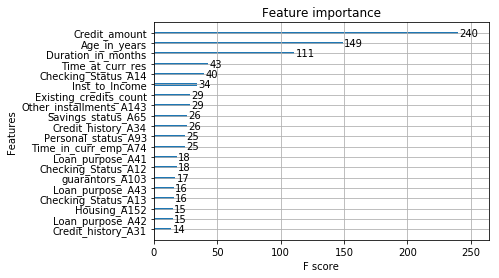

In [20]:
from xgboost import plot_importance
%matplotlib inline
plot_importance(Best_model, max_num_features=20)

y_pre = Best_model.predict(X_test)
y_pro = Best_model.predict_proba(X_test)[:, 1]

print("Accuracy : %.4g" % accuracy_score(y_test, y_pre))
print("AUC Score : %f" %  roc_auc_score(y_test, y_pro))


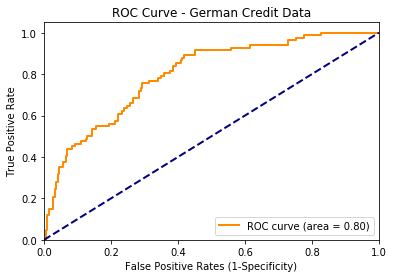

In [21]:
## Plot ROC curve#######

fpr2, tpr2, _ = roc_curve(y_test,
                          y_pro,
                          pos_label = 1)
auc_rf = auc(fpr2, tpr2)

fpr, tpr, thresholds = roc_curve(y_test,y_pro, pos_label = 1)
roc_auc = auc(fpr,tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rates (1-Specificity)')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - German Credit Data')
plt.legend(loc="lower right")
plt.show()